## Installs

In [ ]:
!pip install torchbnn

##Imports

In [ ]:
import numpy as np
import torch as T
import torchbnn as bnn
import time
import matplotlib.pyplot as plt
from sklearn import datasets

device = T.device('cpu')

##Loading Dataset

In [ ]:
class IrisDataset(T.utils.data.Dataset):
  def __init__(self):
    iris = datasets.load_iris()
    tmp_x = iris.data
    tmp_y = iris.target

    self.x_data = T.tensor(tmp_x, dtype=T.float32)
    self.y_data = T.tensor(tmp_y, dtype=T.int64)

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    if T.is_tensor(idx):
      idx = idx.tolist()
    preds = self.x_data[idx]
    spcs = self.y_data[idx]
    sample = { 'predictors' : preds, 'species' : spcs }
    return sample

##Bayesian Neural Network

In [ ]:
class BayesianNet(T.nn.Module):
  def __init__(self):
    super(BayesianNet, self).__init__()
    self.hid1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4, out_features=100)
    self.oupt = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=3)

  def forward(self, x):
    z = T.relu(self.hid1(x))
    z = self.oupt(z)
    return z

## Accuracy Calculator

In [ ]:
def accuracy(model, dataset):
  n = len(dataset)
  X = dataset[0:n]['predictors']
  Y = T.flatten(dataset[0:n]['species'])

  with T.no_grad():
    oupt = model(X)
  arg_maxs = T.argmax(oupt, dim=1)
  num_correct = T.sum(Y==arg_maxs)
  acc = (num_correct * 1.0 / len(dataset))
  return acc.item()

#Training / Testing

In [ ]:
np.random.seed(int(time.time()))
T.manual_seed(int(time.time()))

train_ds = IrisDataset()

epoch_cnt = [10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
x = []
y = []

for epoch_sz in epoch_cnt:
    train_ldr = T.utils.data.DataLoader(train_ds, batch_size=4, shuffle=True)
    net = BayesianNet().to(device)
    max_epochs = epoch_sz
    ep_log_interval = 10

    ce_loss = T.nn.CrossEntropyLoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
    optimizer = T.optim.Adam(net.parameters(), lr=0.01)

    print("max_epochs = %3d " % max_epochs)

    net.train()
    for epoch in range(0, max_epochs):
      epoch_loss = 0

      for (batch_idx, batch) in enumerate(train_ldr):
        X = batch['predictors']
        Y = batch['species']
        optimizer.zero_grad()
        oupt = net(X)

        cel = ce_loss(oupt, Y)
        kll = kl_loss(net)
        tot_loss = cel + (0.10 * kll)

        epoch_loss += tot_loss.item()
        tot_loss.backward()
        optimizer.step()

    net.eval()
    acc = accuracy(net, train_ds)
    print("Accuracy on train data = %0.4f\n" % acc)
    x.append(max_epochs)
    y.append(acc)


Creating Iris train Dataset and DataLoader 
max_epochs =  10 
Accuracy on train data = 0.6733

max_epochs =  20 
Accuracy on train data = 0.9733

max_epochs =  50 
Accuracy on train data = 0.9800

max_epochs = 100 
Accuracy on train data = 0.8800

max_epochs = 150 
Accuracy on train data = 0.9400

max_epochs = 200 
Accuracy on train data = 0.9867

max_epochs = 250 
Accuracy on train data = 0.9867

max_epochs = 300 
Accuracy on train data = 0.9733

max_epochs = 350 
Accuracy on train data = 0.9467

max_epochs = 400 
Accuracy on train data = 0.9467

max_epochs = 450 
Accuracy on train data = 0.9733

max_epochs = 500 
Accuracy on train data = 0.9800

max_epochs = 550 
Accuracy on train data = 0.9867

max_epochs = 600 
Accuracy on train data = 0.9600

max_epochs = 650 
Accuracy on train data = 0.9800

max_epochs = 700 
Accuracy on train data = 0.9667

max_epochs = 750 
Accuracy on train data = 0.9400

max_epochs = 800 
Accuracy on train data = 0.9467

max_epochs = 850 
Accuracy on train d

##Plot

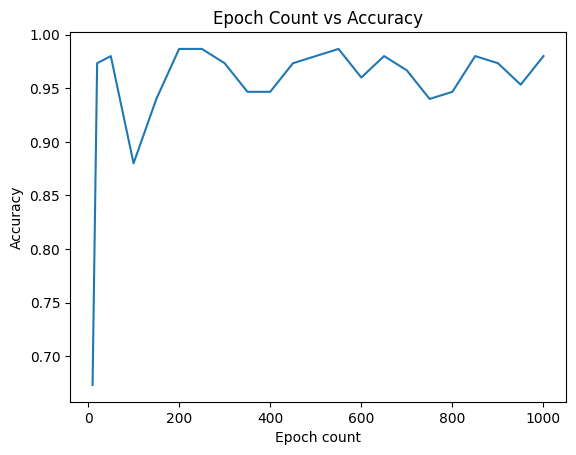

In [ ]:
plt.plot(x, y)
plt.xlabel("Epoch count")
plt.ylabel("Accuracy")
plt.title("Epoch Count vs Accuracy")
plt.show()